# Description

As seen in the course, Continual learning is a problem setting where a model is trained on a sequence of tasks and must perform well on all tasks seen so far. A task is a specific concept or relation the model expects to learn. Online continual learning adds the constraints that the model considers each example exactly once, and the model can perform prediction at any time.

In contrast to continual learning, the typical data stream problem setting adapts to changes in data distribution by discarding knowledge of the past. However, in continual learning, the model must retain knowledge of past tasks while learning new tasks. Continual learning is synonymous with overcoming catastrophic forgetting, a phenomenon in deep learning where a model trained on a sequence of tasks forgets how to perform well on the initial tasks. Non-deep learning models can be immune to forgetting.

In this notebook, we implement “Experience Replay” (ER),one of the strategies seen during the course that stores a buffer of past examples. By sampling from the buffer during training, ER avoids catastrophic forgetting.

# Imports

In [3]:
# CapyMOA
from capymoa.base import BatchClassifier
from capymoa.instance import Instance
from capymoa.stream import Schema
from capymoa.type_alias import LabelProbabilities
from torch.nn.functional import cross_entropy
from capymoa.evaluation.ocl import ocl_train_eval_loop
from capymoa.datasets.ocl import SplitMNIST

# Miscellaneous
import torch
from typing import Tuple
from torch import Tensor
import numpy as np
from torch import nn
from matplotlib import pyplot as plt


# Experience Replay

Experience Replay uses reservoir sampling to construct a simple random sample incrementally from a data stream of unknown length. Here, we implement reservoir sampling “Algorithm R”. This algorithm allows uniform random sampling from a stream of data without knowing its total size in advance. This class maintains a fixed-size buffer (reservoir_x, reservoir_y) that stores examples (x) and their labels (y) as they arrive. Initially, the buffer fills up with incoming data. After the buffer is full, new items replace existing ones with a probability that ensures uniform sampling over time. This is useful in continual learning to maintain a representative and unbiased sample of past experiences.

In [ ]:
class ReservoirSampler:
    def __init__(self, item_count: int, feature_count: int):
        # Number of items to keep in the reservoir
        self.item_count = item_count
        # Number of features in each item
        self.feature_count = feature_count
        # Initialize empty reservoir for features and labels
        self.reservoir_x = torch.zeros((item_count, feature_count))
        self.reservoir_y = torch.zeros((item_count,), dtype=torch.long)
        # Counter to track total number of seen examples
        self.count = 0

    def update(self, x: Tensor, y: Tensor) -> None:
        # x: input tensor of shape (batch_size, feature_count)
        # y: labels tensor of shape (batch_size,)
        batch_size = x.shape[0]
        assert x.shape == (
            batch_size,
            self.feature_count,
        )
        assert y.shape == (batch_size,)

        # Loop over each instance in the batch
        for i in range(batch_size):
            if self.count < self.item_count:
                # Fill the reservoir
                self.reservoir_x[self.count] = x[i]
                self.reservoir_y[self.count] = y[i]
            else:
                # Reservoir full: decide whether to replace an existing item
                index = torch.randint(0, self.count + 1, (1,))
                if index < self.item_count:
                    self.reservoir_x[index] = x[i]
                    self.reservoir_y[index] = y[i]
            self.count += 1

    def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
        # Randomly sample n items from the current reservoir
        indices = torch.randint(0, min(self.count, self.item_count), (n,))
        return self.reservoir_x[indices], self.reservoir_y[indices]

Let’s check to see if it’s samples look uniform.

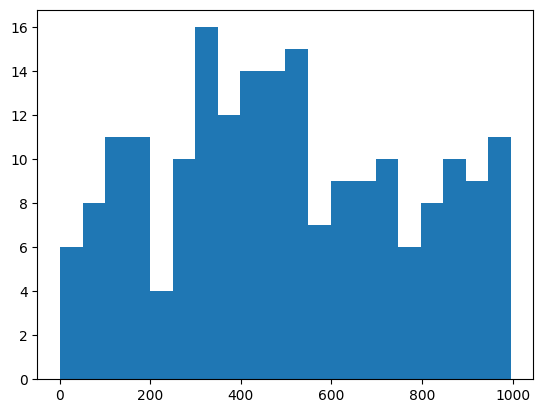

In [5]:
x = torch.arange(0, 1_000).reshape(-1, 1).float()
y = torch.zeros(1_000, dtype=torch.long)
sampler = ReservoirSampler(500, 1)
sampler.update(x, y)
x = sampler.sample_n(200)
plt.hist(x[0].numpy(), bins=20)
plt.show()

The ExperienceReplay class implements the continual learning strategy we previously. It wraps around a PyTorch model and maintains a buffer of past data using a ReservoirSampler. During each training step, it augments the current batch with examples sampled from this buffer. This approach prevents catastrophic forgetting by continuously training on both new and past data, ensuring the model retains performance across earlier tasks or distributions.

In [9]:
class ExperienceReplay(BatchClassifier):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        reservoir_size: int,
        batch_size: int,
        learning_rate: float,
        device: str = "cpu",
    ):
        super().__init__(schema=schema, batch_size=batch_size)

        # Buffer for storing past training examples
        self.reservoir = ReservoirSampler(reservoir_size, schema.get_num_attributes())

         # Optimizer for training the model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

         # The neural network model
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size

    def batch_train(self, x: np.ndarray, y: np.ndarray):
        # Convert input data from NumPy arrays to PyTorch tensors
        x: Tensor = torch.from_numpy(x)
        y: Tensor = torch.from_numpy(y).long()

        # Update the replay buffer with the current batch
        self.reservoir.update(x, y)

        # Sample from the buffer to mix past and current data
        replay_x, replay_y = self.reservoir.sample_n(self.batch_size)

        # Concatenate current and replay data
        train_x = torch.cat((x, replay_x), dim=0).to(self.device)
        train_y = torch.cat((y, replay_y), dim=0).to(self.device)

        # Standard training step
        self.optimizer.zero_grad()
        y_hat = self.model(train_x)
        loss = cross_entropy(y_hat, train_y)
        loss.backward()
        self.optimizer.step()

    @torch.no_grad
    def predict_proba(self, instance: Instance) -> LabelProbabilities:
        # Predict class probabilities for a single instance
        x = torch.from_numpy(instance.x).to(self.device)
        y_hat: Tensor = self.model.forward(x)
        return y_hat.softmax(dim=0).cpu().numpy()

    def __str__(self) -> str:
        return "ExperienceReplay"

We create a simple multi-layer perceptron (MLP) with a single hidden layer to demonstrate continual learning.

The output layer of a neural network is often problematic in continual learning because of the extreme and shifting class imbalance between tasks. We can mitigate this by using a variant of weight normalization that parameterizes the weights as a magnitude (set to the unit vector) and a direction.

In [10]:
class SimpleMLP(nn.Module):
    def __init__(self, schema: Schema, hidden_size: int):
        super().__init__()
        num_classes = schema.get_num_classes()

        self.fc1 = nn.Linear(schema.get_num_attributes(), hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=False)
        self.fc2 = nn.utils.parametrizations.weight_norm(self.fc2, name="weight")
        weight_g = self.fc2.parametrizations.weight.original0
        # Set the magnitude to the unit vector
        weight_g.requires_grad_(False).fill_(1.0 / (num_classes**0.5))

    def forward(self, x: Tensor) -> Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Now we put everything together and demonstrate Continual Learning on the SplitMNIST benchmark using an Experience Replay strategy with a simple MLP. The dataset is split into sequential tasks (like digits 0–1, then 2–3, etc.), and the model is trained on one task at a time, retaining knowledge from previous tasks by sampling from a reservoir of past examples.

During training, ocl_train_eval_loop evaluates the model’s ability to:
* Learn new tasks (forward transfer)
* Retain old tasks (backward transfer)
* General accuracy across tasks
* Online accuracy

In [ ]:
# Load SplitMNIST data as a continual stream of tasks
stream = SplitMNIST()

# Initialize a simple MLP model for classification with hidden size 64
mlp = SimpleMLP(stream.schema, 64)

# Create a continual learner using experience replay
learner = ExperienceReplay(
    stream.schema,
    mlp,
    reservoir_size=200,
    batch_size=64,
    learning_rate=0.01,
    device="cpu",
)

# Run training and evaluation loop over the task stream
r = ocl_train_eval_loop(
    learner,
    stream.train_streams,
    stream.test_streams,
    continual_evaluations=10,
    progress_bar=True,
)

# Report key continual learning metrics
print(f"Forward Transfer  {r.forward_transfer:.2f}")
print(f"Backward Transfer {r.backward_transfer:.2f}")
print(f"Accuracy          {r.accuracy_final:.2f}")
print(f"Online Accuracy   {r.prequential_cumulative_accuracy:.2f}")

Train & Eval: 100%|██████████| 560000/560000 [05:37<00:00, 1658.63it/s]

Forward Transfer  0.00
Backward Transfer -0.18
Accuracy          0.82
Online Accuracy   0.90


Finally, we plot the results. Task 0 start high and decreases as the model forgets the task whereas task 1-4 start at zero since the model has not seen the task yet.

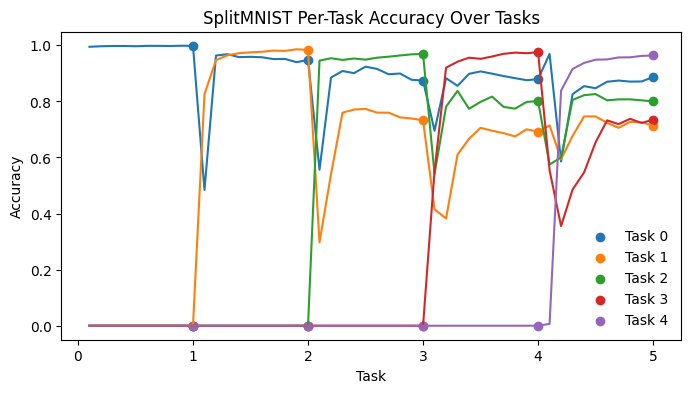

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

cmap = plt.get_cmap("tab10")
for t in range(5):
    ax.scatter(r.task_index, r.accuracy_matrix[:, t], color=cmap(t), label=f"Task {t}")
    ax.plot(r.anytime_task_index, r.anytime_accuracy_matrix[:, t], color=cmap(t))

ax.set_xlabel("Task")
ax.set_xticks(range(6))
ax.set_ylabel("Accuracy")
ax.set_title("SplitMNIST Per-Task Accuracy Over Tasks")
ax.legend(frameon=False)
pass

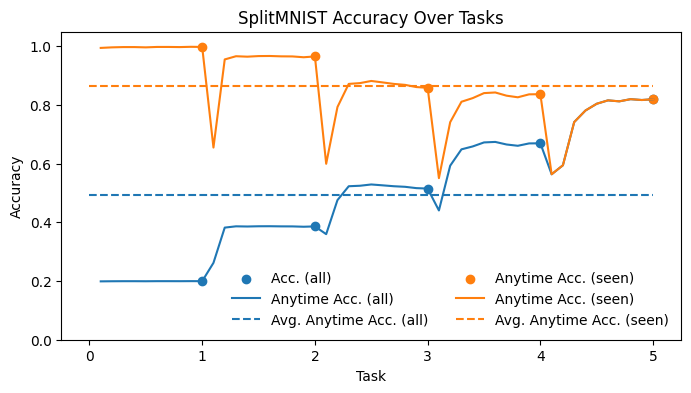

In [12]:
def hline(ax, y, label, color_id):
    ax.hlines(y, 0, 5, linestyles="--", label=label, color=cmap(color_id))


fig, ax = plt.subplots(figsize=(8, 4))
# Plot the accuracy on all tasks over the course of tasks
ax.scatter(r.task_index, r.accuracy_all, label="Acc. (all)")
ax.plot(r.anytime_task_index, r.anytime_accuracy_all, label="Anytime Acc. (all)")
hline(ax, r.anytime_accuracy_all_avg, "Avg. Anytime Acc. (all)", 0)

# Plot the accuracy on previously seen tasks over the course of tasks
ax.scatter(r.task_index, r.accuracy_seen, label="Anytime Acc. (seen)")
ax.plot(r.anytime_task_index, r.anytime_accuracy_seen, label="Anytime Acc. (seen)")
hline(ax, r.anytime_accuracy_seen_avg, "Avg. Anytime Acc. (seen)", 1)

ax.legend(ncol=2, frameon=False)
ax.set_xlabel("Task")
ax.set_xticks(range(6))
ax.set_ylabel("Accuracy")
ax.set_title("SplitMNIST Accuracy Over Tasks")
ax.set_ylim(0, 1.05)
pass